In [1]:
!python3 -m pip install -r /Users/v.ramazaev/src/job-search-analytics/required.txt

In [16]:
import os
from notion_client import AsyncClient

async def get_notion_db():
    token_v2 = os.getenv("NOTION_TOKEN", None)
    database_id = os.getenv("NOTION_DB_ID", None)

    # request the database
    client = AsyncClient(auth=token_v2)
    all_results = []
    start_cursor = None

    while True:
        response = await client.databases.query(
            database_id=database_id,
            start_cursor=start_cursor,
        )
        all_results.extend(response["results"])

        if not response.get("has_more"):
            break

        start_cursor = response["next_cursor"]

    return all_results

Get Data from notion

In [17]:
from datetime import datetime

# get the notion database
notion_db = await get_notion_db()
data = []

for result in notion_db:
    name = result["properties"]["Name"]["title"][0]["text"]["content"]
    job_category = result["properties"]["Job Category"]["multi_select"][0]["name"] if result["properties"]["Job Category"]["multi_select"] else None
    status = result["properties"]["Status"]["select"]["name"] if result["properties"]["Status"]["select"] else None
    applied_date = result["properties"]["Applied"]["date"]["start"] if result["properties"]["Applied"]["date"] else None
    end_date = result["properties"]["End Date"]["date"]["start"] if result["properties"]["End Date"]["date"] else None
    reject_reason = result["properties"]["Reject Reason"]["multi_select"][0]["name"] if result["properties"]["Reject Reason"]["multi_select"] else None

    data.append({
        "Name": name,
        "Job Category": job_category,
        "Status": status,
        "Applied Date": applied_date,
        "End Date": end_date,
        "Reject Reason": reject_reason
    })


APIResponseError: API token is invalid.

# Job by category

                              Name                    
Reject Reason                   CV Screening Technical
Job Category                                          
Post Sale Engineer             5.0       NaN       2.0
Sales Engineer               140.0       6.0       3.0
Senior Engineer               87.0      19.0      10.0
Software/Solution Architect   22.0       2.0       1.0
Staff Engineer                20.0       2.0       3.0
Technical Lead                 8.0       NaN       NaN


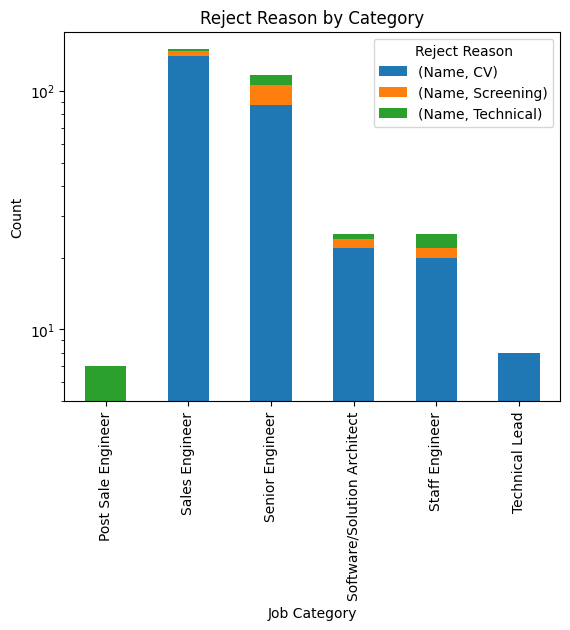

In [15]:
# histogram of job categories
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data)

df.describe()

pivot = df.pivot_table(index=["Job Category"], columns=["Reject Reason"], values=["Name"], aggfunc="count")
pivot.plot(kind="bar", stacked=True)

print(pivot)

plt.title('Reject Reason by Category')
plt.xlabel('Job Category')
plt.ylabel('Count')
plt.legend(title='Reject Reason')
plt.yscale('log')
plt.show()


The distribution between Apply Date and End Date

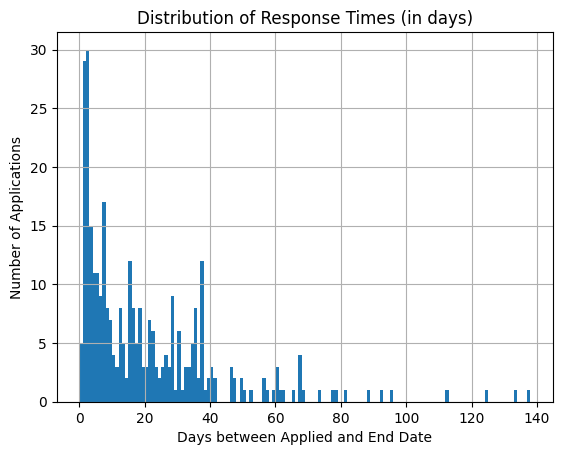

In [5]:
# The distribution between Apply Date and End Date
durations = []
for entry in [entry for entry in data if entry["Applied Date"] and entry["End Date"]]:
    start = datetime.strptime(entry["Applied Date"], "%Y-%m-%d")
    end = datetime.strptime(entry["End Date"], "%Y-%m-%d")
    duration = (end - start).days
    durations.append(duration)

# Plot distribution
plt.hist(durations, bins=range(0, max(durations)+2))
plt.title("Distribution of Response Times (in days)")
plt.xlabel("Days between Applied and End Date")
plt.ylabel("Number of Applications")
plt.grid(True)
plt.show()

In [6]:
durations_df = pd.DataFrame(durations, columns=["Duration"])
durations_df.describe()

,Duration
count,324.000000
mean,20.154321
std,22.352529
min,0.000000
25%,4.000000
50%,13.500000
75%,30.000000
max,137.000000


# Apply Rate by Category

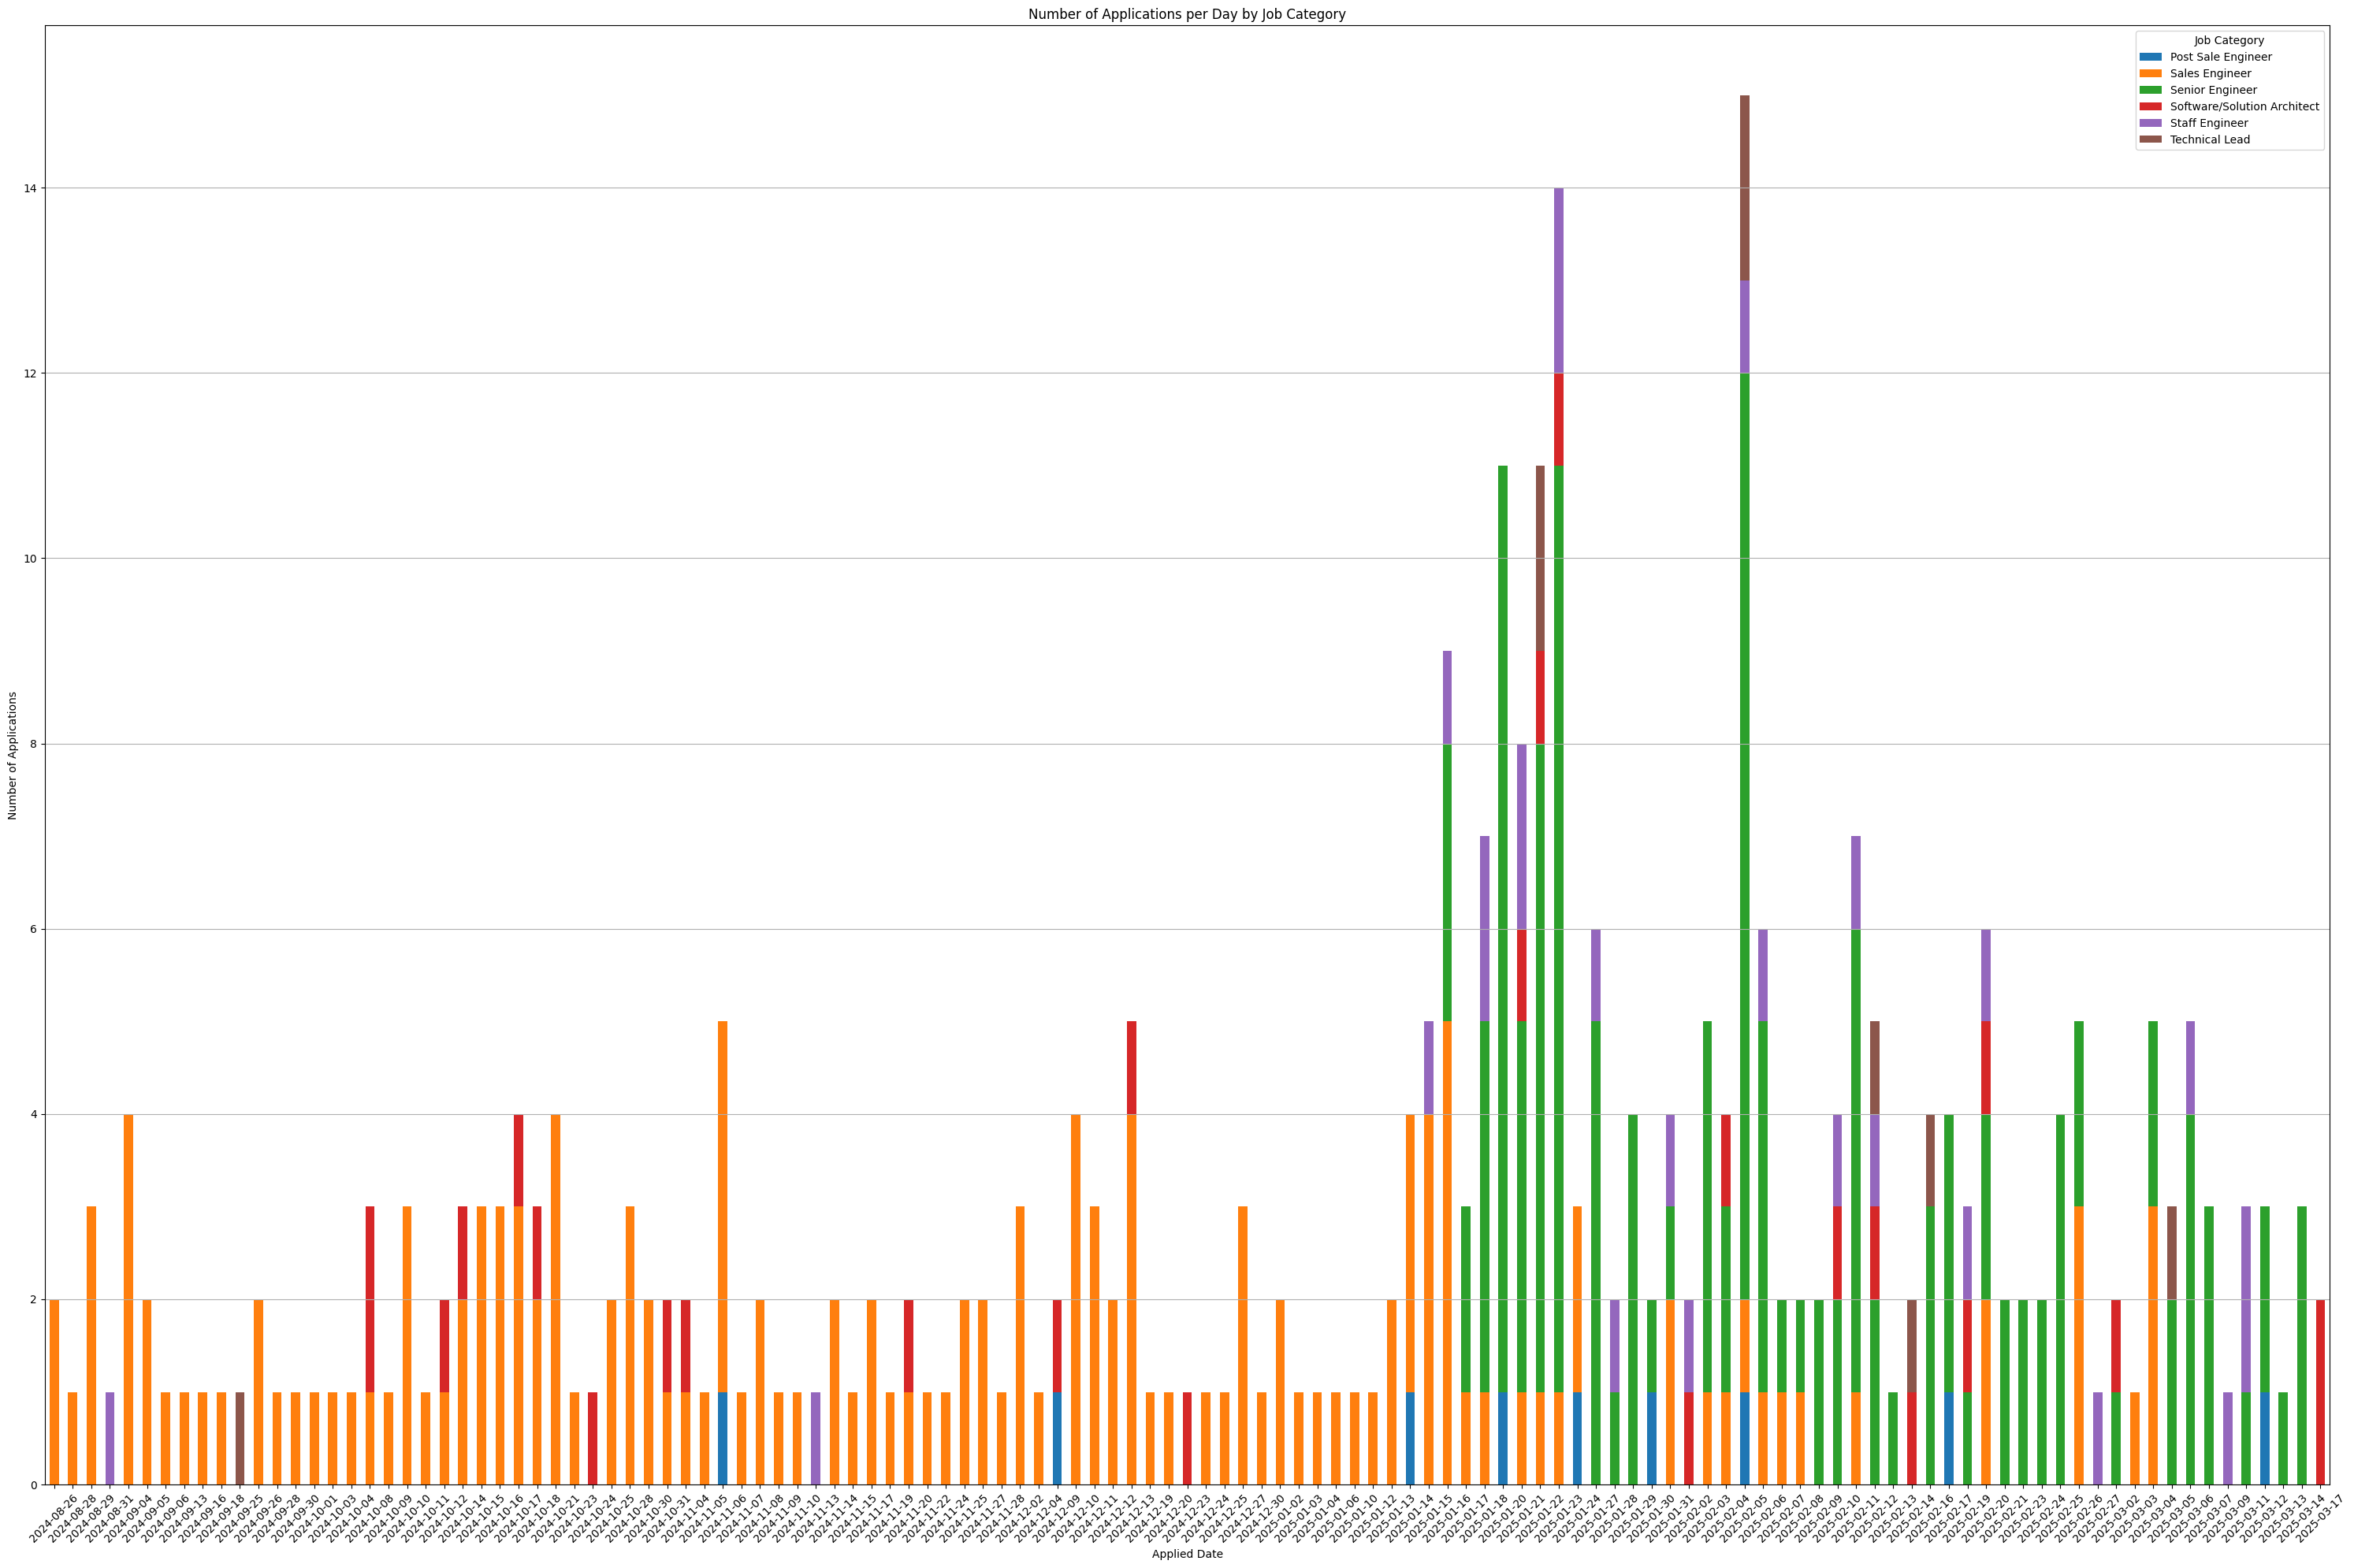

In [7]:
# plot with applications by category

grouped = df.groupby(["Job Category", "Applied Date"]).size().unstack(fill_value=0)
grouped = grouped.reindex(sorted(grouped.columns), axis=1)  # Sort columns by date
grouped = grouped.reindex(sorted(grouped.index), axis=0)  # Sort index by job category
grouped = grouped.fillna(0)  # Fill NaN values with 0

grouped.T.plot(kind="bar", stacked=True, figsize=(30, 20))  # Use kind="line" for a line chart

plt.title("Number of Applications per Day by Job Category")
plt.xlabel("Applied Date")
plt.ylabel("Number of Applications")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

Applied                  343
Screening Invited         52
Interview In Progress     22
Offer                      2
Name: Total, dtype: int64


/var/folders/yp/j4cl1qms0ts9h7vk92zktkwc0000gn/T/ipykernel_41945/1889382605.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  funnel_per_category = df.groupby("Job Category").apply(build_funnel_counts)


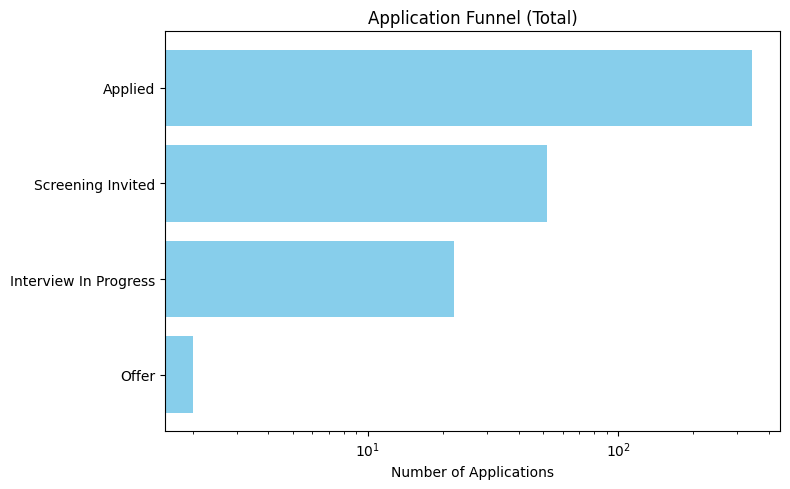

In [8]:
funnel_steps = ["Applied", "Screening Invited", "Interview In Progress", "Offer"]
stage_map = {
    "Applied": 0,
    "Screening Invited": 1,
    "Interview In Progress": 2,
    "Offer": 3
}

def resolve_stage(row):
    if row["Status"] == "Rejected":
        reason = (row.get("Reject Reason") or "").lower()
        if "screening" in reason:
            return "Screening Invited"
        elif "technical" in reason:
            return "Interview In Progress"
        else:
            return "Applied"  # rejected early
    return row["Status"]

df["Resolved Stage"] = df.apply(resolve_stage, axis=1)
df["Stage Index"] = df["Resolved Stage"].map(stage_map)

def build_funnel_counts(subset):
    counts = []
    for i in range(len(funnel_steps)):
        count = (subset["Stage Index"] >= i).sum()
        counts.append(count)
    return pd.Series(counts, index=funnel_steps)

funnel_per_category = df.groupby("Job Category").apply(build_funnel_counts)

funnel_per_category.loc["Total"] = build_funnel_counts(df)

print(funnel_per_category.loc["Total"])

plt.figure(figsize=(8, 5))
plt.barh(funnel_steps[::-1], funnel_per_category.loc["Total"][::-1], color="skyblue")
plt.title("Application Funnel (Total)")
plt.xlabel("Number of Applications")
plt.xscale("log")
plt.tight_layout()
plt.show()


Job Category           Post Sale Engineer  Sales Engineer  Senior Engineer  \
Applied                                 9             152              122   
Screening Invited                       3               9               32   
Interview In Progress                   3               3               12   
Offer                                   1               0                1   

Job Category           Software/Solution Architect  Staff Engineer  \
Applied                                         26              25   
Screening Invited                                3               5   
Interview In Progress                            1               3   
Offer                                            0               0   

Job Category           Technical Lead  Total  
Applied                             9    343  
Screening Invited                   0     52  
Interview In Progress               0     22  
Offer                               0      2  


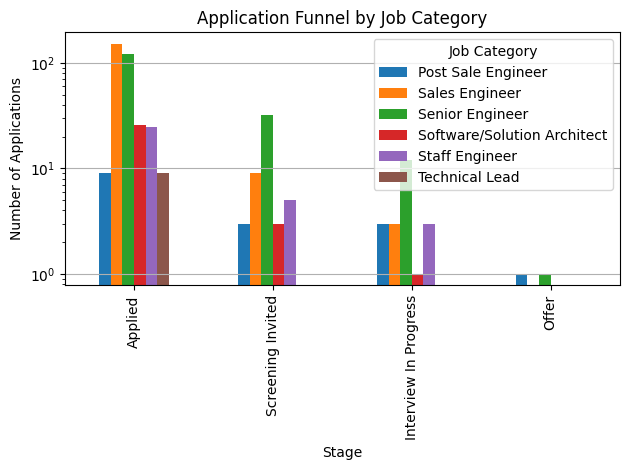

In [9]:
print(funnel_per_category.T)

funnel_per_category.drop("Total").T.plot(kind="bar")
plt.title("Application Funnel by Job Category")
plt.ylabel("Number of Applications")
plt.xlabel("Stage")
plt.grid(axis='y')
plt.yscale('log')
plt.tight_layout()
plt.show()

Conversion Rates from Applied to Later Stages:
Applied → Screening Invited: 15.16%
Applied → Interview In Progress: 6.41%
Applied → Offer: 0.58%


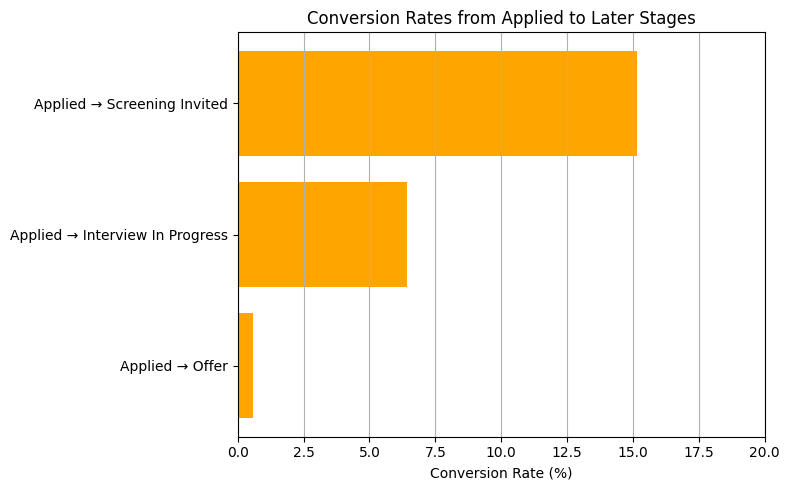

In [10]:
total_funnel = funnel_per_category.loc["Total"]
applied_count = total_funnel["Applied"]

conversion_from_applied = {}
for stage in funnel_steps[1:]:  # skip "Applied" itself
    count = total_funnel[stage]
    if applied_count > 0:
        conversion_from_applied[f"Applied → {stage}"] = round((count / applied_count) * 100, 2)
    else:
        conversion_from_applied[f"Applied → {stage}"] = 0.0

print("Conversion Rates from Applied to Later Stages:")
for stage, rate in conversion_from_applied.items():
    print(f"{stage}: {rate}%")

plt.figure(figsize=(8, 5))
plt.barh(list(conversion_from_applied.keys())[::-1], list(conversion_from_applied.values())[::-1], color="orange")
plt.title("Conversion Rates from Applied to Later Stages")
plt.xlabel("Conversion Rate (%)")
plt.xlim(0, 20)
plt.grid(axis="x")
plt.tight_layout()
plt.show()


Conversion Rates from Applied to Later Stages by Job Category:
Post Sale Engineer:
  Applied → Screening Invited: 33.33%
  Applied → Interview In Progress: 33.33%
  Applied → Offer: 11.11%
Sales Engineer:
  Applied → Screening Invited: 5.92%
  Applied → Interview In Progress: 1.97%
  Applied → Offer: 0.0%
Senior Engineer:
  Applied → Screening Invited: 26.23%
  Applied → Interview In Progress: 9.84%
  Applied → Offer: 0.82%
Software/Solution Architect:
  Applied → Screening Invited: 11.54%
  Applied → Interview In Progress: 3.85%
  Applied → Offer: 0.0%
Staff Engineer:
  Applied → Screening Invited: 20.0%
  Applied → Interview In Progress: 12.0%
  Applied → Offer: 0.0%
Technical Lead:
  Applied → Screening Invited: 0.0%
  Applied → Interview In Progress: 0.0%
  Applied → Offer: 0.0%


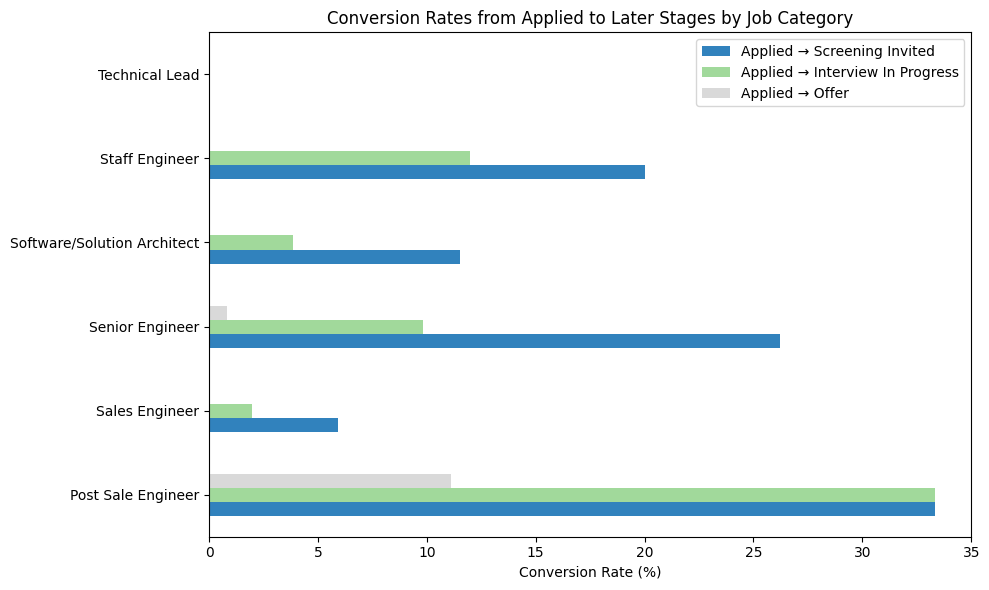

In [11]:
conversion_from_applied_per_cat = {}

for category, row in funnel_per_category.iterrows():
    if category == "Total":
        continue
    applied = row["Applied"]
    category_result = {}
    for stage in funnel_steps[1:]:  # skip "Applied"
        stage_count = row[stage]
        if applied > 0:
            rate = round((stage_count / applied) * 100, 2)
        else:
            rate = 0.0
        category_result[f"Applied → {stage}"] = rate
    conversion_from_applied_per_cat[category] = category_result

print("\nConversion Rates from Applied to Later Stages by Job Category:")
for category, rates in conversion_from_applied_per_cat.items():
    print(f"{category}:")
    for stage, rate in rates.items():
        print(f"  {stage}: {rate}%")

# Convert to DataFrame for display and plotting
conversion_df = pd.DataFrame(conversion_from_applied_per_cat).T

conversion_df.plot(kind="barh", figsize=(10, 6), stacked=False, colormap='tab20c')
plt.title("Conversion Rates from Applied to Later Stages by Job Category")
plt.xlabel("Conversion Rate (%)")
plt.xlim(0, 35)
plt.tight_layout()
plt.show()

# Conversion of Staff Engineer (CV)

In [12]:
# Filter for the selected categories
selected_categories = ["Technical Lead", "Senior Engineer", "Staff Engineer"]
filtered_funnel = funnel_per_category.loc[selected_categories]

# Sum up the values across the selected categories for total conversion calculation
total_funnel_selected = filtered_funnel.sum()

# Calculate conversion rates from "Applied" to other stages
applied_count = total_funnel_selected["Applied"]
conversion_from_applied = {}

for stage in funnel_steps[1:]:  # Skip "Applied" itself
    count = total_funnel_selected[stage]
    if applied_count > 0:
        conversion_from_applied[f"Applied → {stage}"] = round((count / applied_count) * 100, 2)
    else:
        conversion_from_applied[f"Applied → {stage}"] = 0.0

# Print the conversion rates
print("Total Conversion Rates from Applied to Later Stages (for selected categories):")
for stage, rate in conversion_from_applied.items():
    print(f"{stage}: {rate}%")


Total Conversion Rates from Applied to Later Stages (for selected categories):
Applied → Screening Invited: 23.72%
Applied → Interview In Progress: 9.62%
Applied → Offer: 0.64%


# Conversion of Solutions Architect (CV)


In [13]:
# Filter for the selected categories
selected_categories = ["Post Sale Engineer", "Sales Engineer", "Software/Solution Architect"]
filtered_funnel = funnel_per_category.loc[selected_categories]

# Sum up the values across the selected categories for total conversion calculation
total_funnel_selected = filtered_funnel.sum()

# Calculate conversion rates from "Applied" to other stages
applied_count = total_funnel_selected["Applied"]
conversion_from_applied = {}

for stage in funnel_steps[1:]:  # Skip "Applied" itself
    count = total_funnel_selected[stage]
    if applied_count > 0:
        conversion_from_applied[f"Applied → {stage}"] = round((count / applied_count) * 100, 2)
    else:
        conversion_from_applied[f"Applied → {stage}"] = 0.0

# Print the conversion rates
print("Total Conversion Rates from Applied to Later Stages (for selected categories):")
for stage, rate in conversion_from_applied.items():
    print(f"{stage}: {rate}%")

Total Conversion Rates from Applied to Later Stages (for selected categories):
Applied → Screening Invited: 8.02%
Applied → Interview In Progress: 3.74%
Applied → Offer: 0.53%
